In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re
import random

from sklearn.model_selection import StratifiedKFold

from transformers import AutoTokenizer, TweetTokenizer

import torch
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

from nn_models import (BiGRUClassifier, BiRNNClassifier, BiLSTMClassifier,
                      CNNClassifier, BERTTweetDataset, BERTweetClassifier)

from nn_training import cross_validate, cross_validate_bertweet

from nlp import build_vocab_and_tokenize, TweetDataset, collate_fn

from eval_utils import clean_text_for_twitter_glove, plot_models_heatmap, clean_text_for_twitter_glove

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

### 1. Загрузка данных и предварительная обработка

Загружаем данные и проводим предварительную обработку. Пропуски в поле keyword — заполняем пустой строкой и объединяем с исходным текстом твита text + ' ' + keyword.

In [ ]:
df = pd.read_csv('kaggle/input/nlp-getting-started/train.csv')


In [ ]:
df['keyword'].fillna('', inplace=True)
df['full_text'] = df['text'] + ' ' + df['keyword']

/tmp/ipykernel_47/1725234625.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['keyword'].fillna('', inplace=True)


Очищаем текст -  удалим: ссылки (http, www, https), упоминания пользователей (@) и решетки (#)

In [10]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', ' url ', text)
    text = re.sub(r'@\w+', ' user ', text)
    text = re.sub(r'#(\w+)', r'\1', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text
    
df['clean_text'] = df['text'].apply(clean_text)

Проведем анализ длин очищенных текстовю. Для этого строим гистограмма распределения длин (в токенах).

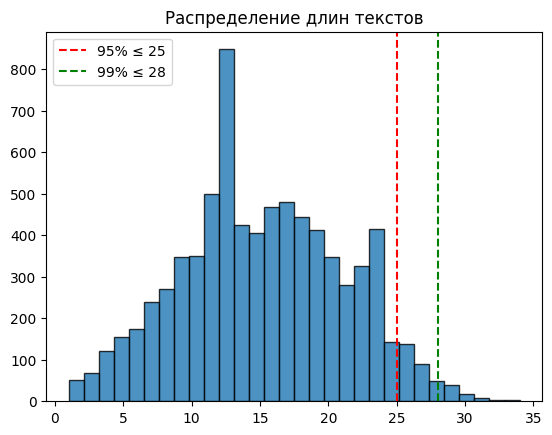

95% текстов ≤ 25.0
99% текстов ≤ 28.0


In [ ]:
lengths = [len(text.split()) for text in df['clean_text']]

p95 = np.percentile(lengths, 95)
p99 = np.percentile(lengths, 99)

plt.hist(lengths, bins=30, edgecolor='black', alpha=0.8)

plt.axvline(p95, color='red', linestyle='--', label=f'95% ≤ {p95:.0f}')
plt.axvline(p99, color='green', linestyle='--', label=f'99% ≤ {p99:.0f}')

plt.legend()
plt.title('Распределение длин текстов')
plt.show()

print(f"95% текстов ≤ {p95}")
print(f"99% текстов ≤ {p99}")

Видим что 95% текстов ≤ 25 токенов и 99% текстов ≤ 28 токенов. Ограничиваем макс. длину последовательности токенов в одном твите MAX_LEN = 30.

Проходимся по всем текстам из тренировочной выборки и разбиваем их на токены, подсчитываем частоту каждого из них, учитывая при этом только первые MAX_LEN токенов в каждом из примеров

Далее сформируем словарь (vocab), который начинается с токенов <pad> [0] и <unk> [1], и включаем в него слова, которые встречаются не реже MIN_DF раз. Создаем отображение word2idx (слово - индекс) 

После этого все текста преобразуем в последовательности числовых индексов (train_indices): неизвестные слова заменяем на <unk> а длины текстов граничиваем MAX_LEN

In [ ]:
MAX_LEN = 30
MIN_DF = 2

vocab, word2idx, vocab_size, train_indices = build_vocab_and_tokenize(
    df, MAX_LEN, MIN_DF, col='clean_text'
)

In [21]:
vocab_size

6510

Переходим обучению моделей. Эксперименты включают 
- двунаправленные модификации RNN, GRU и LSTM, 
- CNN с эмбеддингами GloVe (Twitter 100d),
- преобученную трансформерную модель BERTweet, обученную на корпусе англоязычных твитов. 

Для оценки качества  каждой архитектуры используется 5-фолдовая стратифицированная кросс-валидация

Для каждого фолда создаются свои обучающая и валидационная выборки. В процессе обучения применяютя:

- оптимизатор AdamW (в отличии от Adam - веса градиента уменьшаются напрямую, минуя 1 и 2 моменты (усредненный градиент и квадрат градиентов) == их равномерное уменьшение) с параметрами lr = 0.001 и weight_decay = 0.01;

- функция потерь BCEWithLogitsLoss (комбинация сигмоиды и бинарной кросс энтропии);

- градиентный клиппинг (нормировка градиентов) для стабилизации;

- ReduceLROnPlateau для адаптивного уменьшения learning rate;

- 50 эпох с использованием Early Stopping, который останавливает обучение, если F1-score перестал улучшаться

### RNN 

In [ ]:
N_SPLITS = 5

cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

In [22]:
SEED = 42
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
VOCAB_SIZE = 10000
EMBED_DIM = 128
HIDDEN_DIM = 256
NUM_LAYERS = 2
DROPOUT = 0.5
EPOCHS = 50
BATCH_SIZE = 128
N_SPLITS = 5
LR = 0.001
WEIGHT_DECAY = 0.01

[INFO] ===== FOLD 1/5 =====
Fold 1:  24%|██▍       | 12/50 [00:07<00:21,  1.79it/s, loss=0.6316, val_f1=0.5537][INFO] Early stopping on epoch 13 — best F1: 0.6215 (epoch 8)
[INFO] ===== FOLD 2/5 =====                                                        
Fold 2:  56%|█████▌    | 28/50 [00:16<00:12,  1.79it/s, loss=0.4489, val_f1=0.6885][INFO] Early stopping on epoch 29 — best F1: 0.6904 (epoch 24)
[INFO] ===== FOLD 3/5 =====                                                        
Fold 3:  14%|█▍        | 7/50 [00:04<00:24,  1.79it/s, loss=0.6811, val_f1=0.0091][INFO] Early stopping on epoch 8 — best F1: 0.5236 (epoch 3)
[INFO] ===== FOLD 4/5 =====                                                       
Fold 4:  12%|█▏        | 6/50 [00:03<00:24,  1.78it/s, loss=0.6821, val_f1=0.0061][INFO] Early stopping on epoch 7 — best F1: 0.6014 (epoch 2)
[INFO] ===== FOLD 5/5 =====                                                       
Fold 5:  12%|█▏        | 6/50 [00:03<00:24,  1.79it/s, loss=0

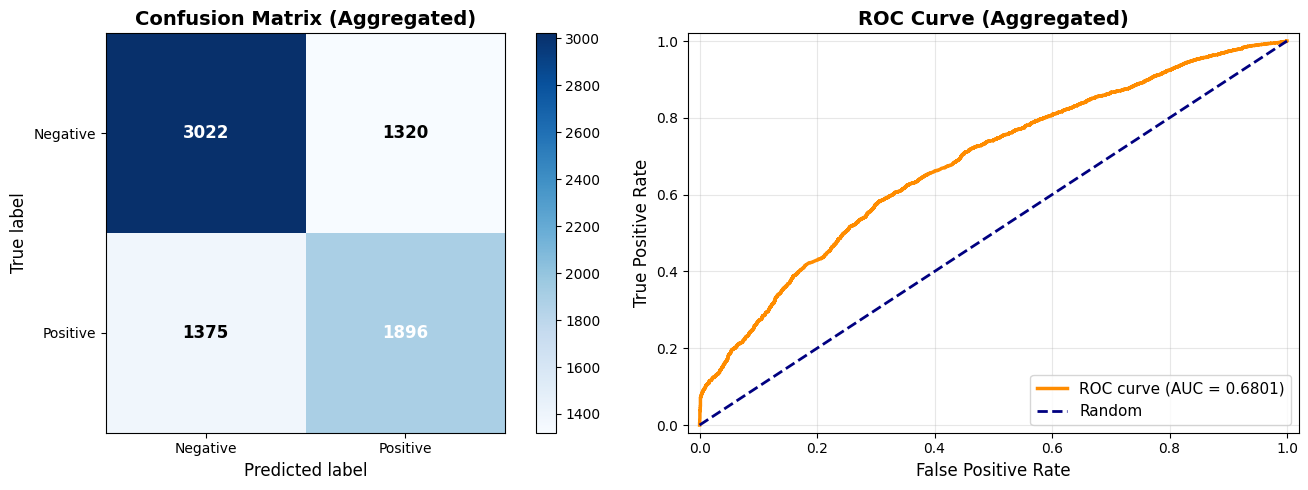

[INFO] Total time: 36.4s (0.6 min)


In [ ]:
rnn_model = BiRNNClassifier(
    vocab_size=VOCAB_SIZE,
    embed_dim=EMBED_DIM,
    hidden_dim=HIDDEN_DIM,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT
)


rnn_metrics = cross_validate(
    model=rnn_model,
    train_indices=train_indices,
    labels=df['target'].values,
    cv=cv,
    dataset_class=TweetDataset,
    collate_fn=collate_fn,
    device=DEVICE,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    lr=LR,
    weight_decay=WEIGHT_DECAY,
    patience=5
)

### GRU

[INFO] ===== FOLD 1/5 =====
Fold 1:  34%|███▍      | 17/50 [00:16<00:30,  1.08it/s, loss=0.3511, val_f1=0.7227][INFO] Early stopping on epoch 18 — best F1: 0.7292 (epoch 13)
[INFO] ===== FOLD 2/5 =====                                                        
Fold 2:  20%|██        | 10/50 [00:10<00:37,  1.08it/s, loss=0.3801, val_f1=0.7048][INFO] Early stopping on epoch 11 — best F1: 0.7056 (epoch 6)
[INFO] ===== FOLD 3/5 =====                                                        
Fold 3:  34%|███▍      | 17/50 [00:16<00:30,  1.08it/s, loss=0.3172, val_f1=0.6922][INFO] Early stopping on epoch 18 — best F1: 0.6965 (epoch 13)
[INFO] ===== FOLD 4/5 =====                                                        
Fold 4:  36%|███▌      | 18/50 [00:17<00:29,  1.08it/s, loss=0.2978, val_f1=0.7419][INFO] Early stopping on epoch 19 — best F1: 0.7536 (epoch 14)
[INFO] ===== FOLD 5/5 =====                                                        
Fold 5:  36%|███▌      | 18/50 [00:17<00:29,  1.08it/

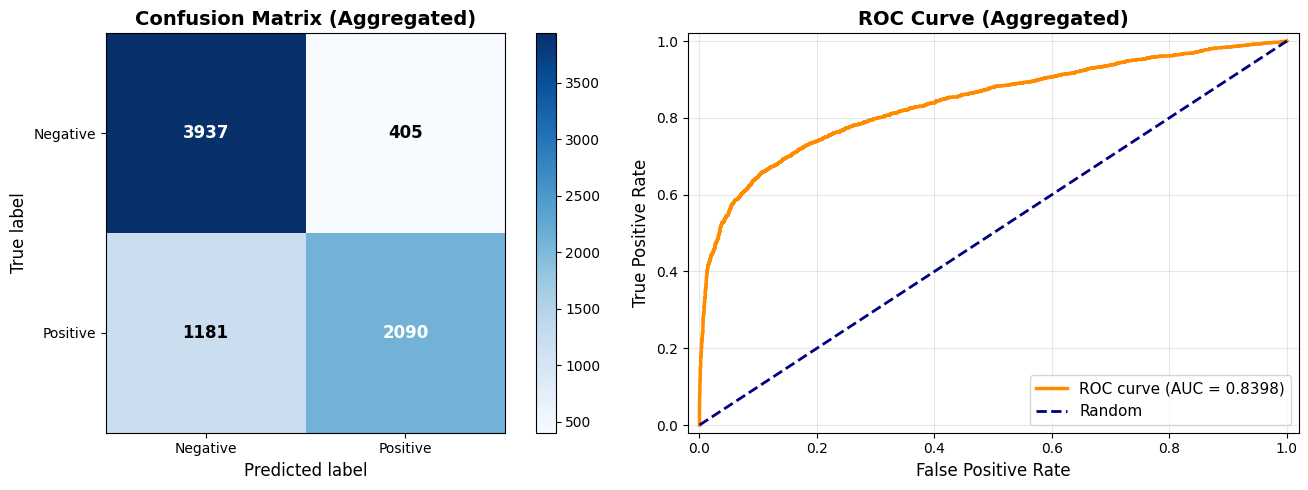

[INFO] Total time: 79.3s (1.3 min)


In [ ]:
model = BiGRUClassifier(
    vocab_size=VOCAB_SIZE,
    embed_dim=EMBED_DIM,
    hidden_dim=HIDDEN_DIM,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

gru_metrics = cross_validate(
    model=model,
    train_indices=train_indices,
    labels=df['target'].values,
    cv=cv,
    dataset_class=TweetDataset,
    collate_fn=collate_fn,
    device=DEVICE,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    lr=LR,
    weight_decay=WEIGHT_DECAY,
    patience=5
)

### LSTM

[INFO] ===== FOLD 1/5 =====
Fold 1:  66%|██████▌   | 33/50 [00:34<00:17,  1.02s/it, loss=0.2921, val_f1=0.7220][INFO] Early stopping on epoch 34 — best F1: 0.7329 (epoch 29)
[INFO] ===== FOLD 2/5 =====                                                        
Fold 2:  36%|███▌      | 18/50 [00:19<00:32,  1.02s/it, loss=0.3696, val_f1=0.7043][INFO] Early stopping on epoch 19 — best F1: 0.7134 (epoch 14)
[INFO] ===== FOLD 3/5 =====                                                        
Fold 3:  18%|█▊        | 9/50 [00:10<00:41,  1.02s/it, loss=0.4017, val_f1=0.6823][INFO] Early stopping on epoch 10 — best F1: 0.6904 (epoch 5)
[INFO] ===== FOLD 4/5 =====                                                       
Fold 4:  38%|███▊      | 19/50 [00:20<00:31,  1.02s/it, loss=0.2934, val_f1=0.7162][INFO] Early stopping on epoch 20 — best F1: 0.7276 (epoch 15)
[INFO] ===== FOLD 5/5 =====                                                        
Fold 5:  42%|████▏     | 21/50 [00:22<00:29,  1.02s/it,

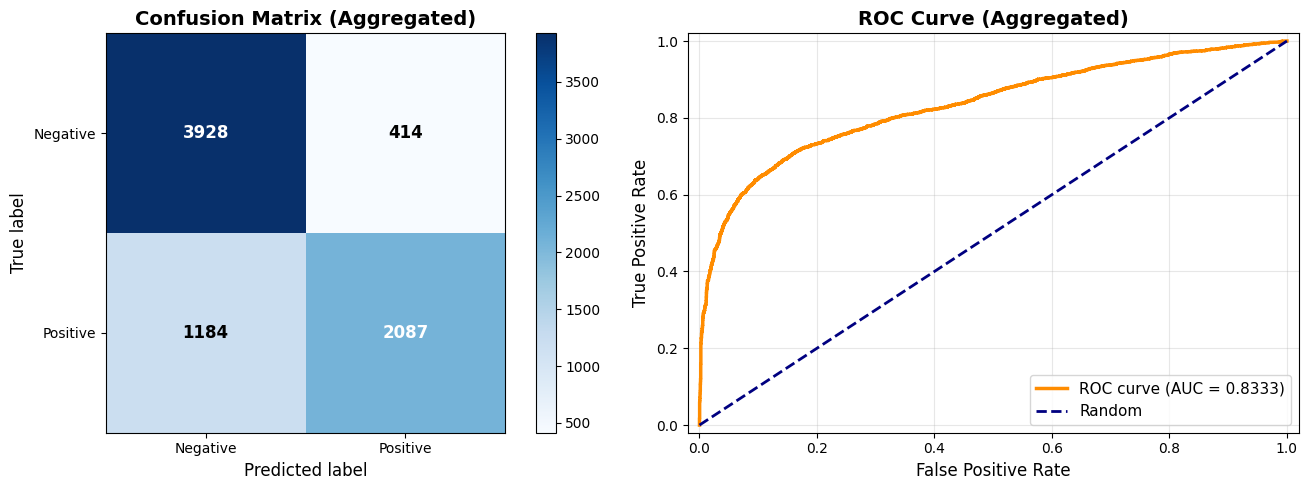

[INFO] Total time: 107.3s (1.8 min)


In [ ]:
cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

lstm_model = BiLSTMClassifier(
    vocab_size=VOCAB_SIZE,
    embed_dim=EMBED_DIM,
    hidden_dim=HIDDEN_DIM,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT
)
lstm_model.to(device)

lstm_metrics = cross_validate(
    model=lstm_model,
    train_indices=train_indices,
    labels=df['target'].values,
    cv=cv,
    dataset_class=TweetDataset,
    collate_fn=collate_fn,
    device=DEVICE,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    lr=LR,
    weight_decay=WEIGHT_DECAY,
    patience=5
)


### CNN + предобученные эмбеддинги

- Загружаем предобученных эмбеддинги GloVe Twitter  (https://nlp.stanford.edu/data/glove.twitter.27B.zip). Используем 100-мерные векторы.
- Чтобы сопоставить слова из наших твитов с предобученными эмбедингами, зададим функцию, которая проходит по всем строкам файла GloVe и заменяет случайные эмбеддинги на предобученные, если слово есть в нашем словре
- Произведем предобработку текста (нижний регистр, заменить ссылки на <url>, упоминания пользователей на <user>, # на <hashtag>, числа на <number>, лишние символы и пробелы)
- Пересоздаем словарь и токенизацию используя обработанный текст

- Инициализируем CNN с несколькими фильтрами с разными размерами ядер (3, 4, 5) чтобы захватить соответствующие n-граммы


In [15]:
!wget https://nlp.stanford.edu/data/glove.twitter.27B.zip

--2025-12-22 18:32:01--  https://nlp.stanford.edu/data/glove.twitter.27B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip [following]
--2025-12-22 18:32:02--  https://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1520408563 (1.4G) [application/zip]
Saving to: ‘glove.twitter.27B.zip’

glove.twitter.27B.z 100%[===================>]   1.42G  5.15MB/s    in 4m 52s  

2025-12-22 18:36:55 (4.96 MB/s) - ‘glove.twitter.27B.zip’ saved [1520408563/1520408563]



In [16]:
!unzip glove.twitter.27B.zip

Archive:  glove.twitter.27B.zip
  inflating: glove.twitter.27B.25d.txt  
  inflating: glove.twitter.27B.50d.txt  
  inflating: glove.twitter.27B.100d.txt  
  inflating: glove.twitter.27B.200d.txt  


In [17]:
def load_glove_twitter(filepath, word2idx, embed_dim=100):
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), embed_dim))
    embeddings[0] = 0  # <pad>
    
    found = 0
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            if word in word2idx:
                vector = np.array(values[1:], dtype='float32')
                embeddings[word2idx[word]] = vector
                found += 1
    
    print(f"Найдено {found}/{len(word2idx)} слов в GloVe Twitter")
    return torch.FloatTensor(embeddings)

In [ ]:
df['clean_glove_text'] = df['text'].apply(clean_text_for_twitter_glove)

MAX_LEN = 30
MIN_DF = 2

vocab_glove, word2idx_glove, vocab_size_glove, train_indices_glove = build_vocab_and_tokenize(
     df, MAX_LEN, MIN_DF, col = 'clean_glove_text'
)

print(f"Размер словаря: {vocab_size}")

Размер словаря: 6510
Найдено 6038/6368 слов в GloVe Twitter


In [ ]:
pretrained_emb = load_glove_twitter(
    '/kaggle/working/glove.twitter.27B.100d.txt',
    word2idx_glove,
    embed_dim=100
)

[INFO] ===== FOLD 1/5 =====
Fold 1:  34%|███▍      | 17/50 [00:06<00:12,  2.69it/s, loss=0.1274, val_f1=0.7906][INFO] Early stopping on epoch 18 — best F1: 0.7945 (epoch 8)
[INFO] ===== FOLD 2/5 =====                                                        
Fold 2:  28%|██▊       | 14/50 [00:05<00:13,  2.67it/s, loss=0.1253, val_f1=0.7754][INFO] Early stopping on epoch 15 — best F1: 0.7835 (epoch 5)
[INFO] ===== FOLD 3/5 =====                                                        
Fold 3:  28%|██▊       | 14/50 [00:05<00:13,  2.69it/s, loss=0.1237, val_f1=0.7478][INFO] Early stopping on epoch 15 — best F1: 0.7621 (epoch 5)
[INFO] ===== FOLD 4/5 =====                                                        
Fold 4:  30%|███       | 15/50 [00:05<00:13,  2.68it/s, loss=0.1014, val_f1=0.7639][INFO] Early stopping on epoch 16 — best F1: 0.7808 (epoch 6)
[INFO] ===== FOLD 5/5 =====                                                        
Fold 5:  26%|██▌       | 13/50 [00:05<00:13,  2.71it/s, 

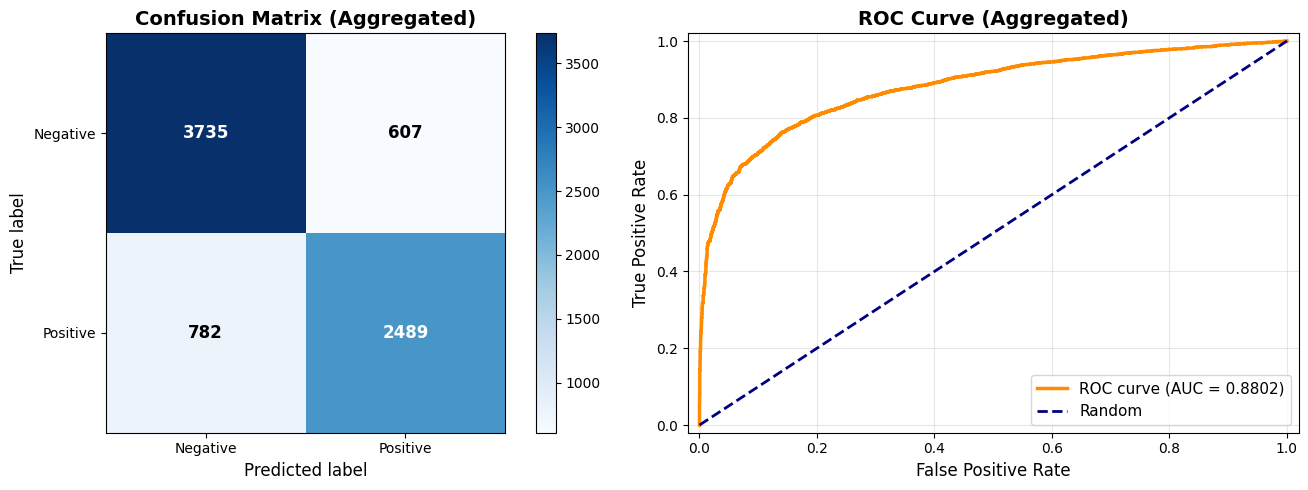

[INFO] Total time: 29.5s (0.5 min)


In [ ]:
cnn_model = CNNClassifier(
    vocab_size=VOCAB_SIZE,
    embed_dim=EMBED_DIM,
    num_filters=100,
    filter_sizes=[3, 4, 5],
    dropout=DROPOUT,
    pretrained_embeddings=pretrained_emb
)

cnn_metrics = cross_validate(
    model=cnn_model,
    train_indices=train_indices_glove,
    labels=df['target'].values,
    cv=cv,
    dataset_class=TweetDataset,
    collate_fn=collate_fn,
    device=DEVICE,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    lr=LR,
    weight_decay=WEIGHT_DECAY,
    patience=10
)

- описать как инициализируем трансформер, какой именно используем (vinai/bertweet-base)
- как создаем датасет 
- как устроен train fold и cross validate
- как устроен ТОКЕНИЗАТОР, ПРЕПРОЦЕССИНГ ДЛЯ BERTWEET, подготовка данных

### BERTweet

BERTweet — это BERT-подобная архитектура, адаптированная под особенности твитов (смайлы, упоминания, хэштеги, сленг).

Вначале загружаем предобученную модель через transformers.AutoModel, добавляем дропаут и линейный слой, в конце прямого проходе используем CLS токен всего твита

Создаем датасет, токенизируя твиты с помощью transformers.AutoTokenizer

Во время обучения используем оптимизатор AdamW, линейный warmup и decay sheduller (скорость обучения сначала линейно увеличивается, а потом уменьшается)

Задаем параметры: 
- `MAX_LENGTH = 128` — максимальная длина твита.
- `BERT_BATCH_SIZE = 32` — размер батча.
- `BERT_EPOCHS = 6` — количество эпох на fold.
- `BERT_LR = 2e-5` — learning rate.
- `patience = 3` — ранняя остановка по F1

In [4]:
#!pip install protobuf==3.20.*

In [ ]:
BERT_MODEL = 'vinai/bertweet-base'
MAX_LENGTH = 128
BERT_BATCH_SIZE = 32
BERT_EPOCHS = 6
BERT_LR = 2e-5

tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL, use_fast=False)

tweet_tokenizer = TweetTokenizer()

def normalize_tweet(text):
    """
    Нормализация твитов для BERTweet [web:29].
    """
    tokens = tweet_tokenizer.tokenize(text)
    normalized = ' '.join(tokens)
    return normalized

df['bertweet_text'] = df['text'].apply(normalize_tweet)

# cоздаем полный датасет без разделения на train/val
full_dataset = BERTTweetDataset(
    texts=df['bertweet_text'].values,
    labels=df['target'].values,
    tokenizer=tokenizer,
    max_length=MAX_LENGTH
)

bert_metrics, best_model = cross_validate_bertweet(
    model_class=BERTweetClassifier,
    model_kwargs={'model_name': BERT_MODEL, 'dropout': 0.3},
    full_dataset=full_dataset,
    device=DEVICE,
    n_splits=5, 
    batch_size=BERT_BATCH_SIZE,
    epochs=BERT_EPOCHS,
    lr=BERT_LR,
    patience=3,
    random_state=42,
    use_amp=True
)

[INFO] Starting 5-fold cross-validation
[INFO] FOLD 1/5
[INFO] Fold 1 Results: Acc=0.8490, Prec=0.8455, Rec=0.7939, F1=0.8189, ROC-AUC=0.9018
[INFO] FOLD 2/5
[INFO] Fold 2 Results: Acc=0.8490, Prec=0.8533, Rec=0.7829, F1=0.8166, ROC-AUC=0.8989
[INFO] FOLD 3/5
[INFO] Fold 3 Results: Acc=0.8359, Prec=0.8196, Rec=0.7920, F1=0.8056, ROC-AUC=0.8820
[INFO] FOLD 4/5
[INFO] Fold 4 Results: Acc=0.8417, Prec=0.8380, Rec=0.7829, F1=0.8095, ROC-AUC=0.8945
[INFO] FOLD 5/5
[INFO] Fold 5 Results: Acc=0.8357, Prec=0.7979, Rec=0.8272, F1=0.8123, ROC-AUC=0.9033
[INFO] ACCURACY    : 0.8422 ± 0.0059
[INFO] PRECISION   : 0.8309 ± 0.0199
[INFO] RECALL      : 0.7958 ± 0.0164
[INFO] F1          : 0.8126 ± 0.0048
[INFO] ROC_AUC     : 0.8961 ± 0.0077
[INFO] 
Best model loaded (F1=0.8189)


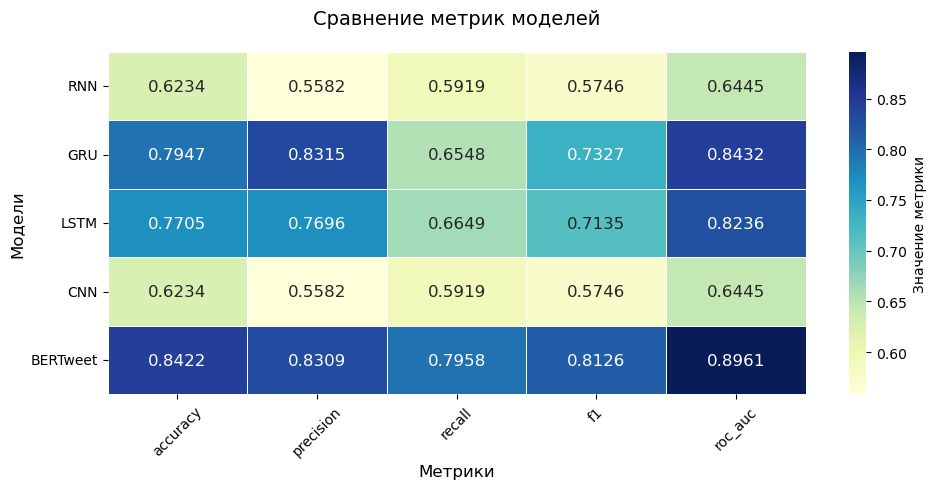

In [ ]:

plot_models_heatmap(
    metrics_list=[
        rnn_metrics['aggregated'],
        gru_metrics['aggregated'],
        lstm_metrics['aggregated'],
        cnn_metrics['aggregated'],
        bert_metrics['aggregated'] 
    ],
    model_names=["RNN", "GRU", "LSTM", "CNN", "BERTweet"],
    title="Сравнение метрик моделей"
)

#### Выводы

- BERTweet побеждает по всем 4 метрикам качества. Предобученная на твитах модель хорошо понимает их контекст.
- GRU и LSTM выдали чуть худшие метрики
- CNN и RNN проигрывают по всем метрикам

Таким образом, если важна точность лучше выбрать BERTweet, если скорость/ресурсы - GRU или LSTM